# Bigram Analysis of Trykkefrihedens Skrifter

This notebook performs bigram (word pair) analysis on *Trykkefrihedens Skrifter* in Python, inspired by the R workflow.

## 1. Install and Import Dependencies

If you're missing any packages, uncomment and run the pip cell below.

In [1]:
# !pip install pandas numpy nltk matplotlib seaborn networkx

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lakj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lakj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Load Data

We load the main data and stopwords from CSV files.

In [2]:
main_data_path = 'tfs_data/tfs_structured.csv'
stopwords_path = 'tfs_data/tfs_stopord.csv'

try:
    tfs = pd.read_csv(main_data_path)
    print(f'Data loaded. Shape: {tfs.shape}')
except FileNotFoundError:
    print(f'File not found: {main_data_path}')
    tfs = None

try:
    stopord_tfs = pd.read_csv(stopwords_path)['word'].astype(str).str.lower().tolist()
    print(f'Loaded {len(stopord_tfs)} project-specific stopwords.')
except Exception as e:
    print(f'Could not load project-specific stopwords: {e}')
    stopord_tfs = []

# Optional extra stopwords list from URL (can be added if desired)
# stopord_url = "https://gist.githubusercontent.com/maxodsbjerg/4d1e3b1081ebba53a8d2c3aae2a1a070/raw/e1f63b4c81c15bb58a54a2f94673c97d75fe6a74/stopord_18.csv"
# stopord_extra = pd.read_csv(stopord_url)['word'].astype(str).str.lower().tolist()
# stopord_tfs += stopord_extra

Data loaded. Shape: (28133, 14)
Loaded 60 project-specific stopwords.


## 3. Formation of Bigrams

We create bigrams (word pairs) for each text.

In [3]:
def regex_tokenize(text):
    # Simple tokenization, can be extended if needed
    return re.findall(r'\b\S+\b', str(text).lower())

def make_bigrams(tokens):
    return [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]

# Create bigrams for all rows
bigrams_list = []
for idx, row in tfs.iterrows():
    tokens = regex_tokenize(row['content'])
    bigrams = make_bigrams(tokens)
    for bg in bigrams:
        bigrams_list.append({'refnr': row.get('refnr', idx),
                             'række': row.get('række', None),
                             'bind': row.get('bind', None),
                             'side': row.get('side', None),
                             'word1': bg[0],
                             'word2': bg[1]})

tfs_bigrams = pd.DataFrame(bigrams_list)
print(f'Number of bigrams: {len(tfs_bigrams)}')
display(tfs_bigrams.head())

Number of bigrams: 4402472


,refnr,række,bind,side,word1,word2
0,1.1.1,1,1,1,philopatreias,trende
1,1.1.1,1,1,1,trende,anmærkninger
2,1.1.1,1,1,1,anmærkninger,i
3,1.1.1,1,1,1,i,om
4,1.1.1,1,1,1,om,de


## 4. Count Bigrams

We count the frequency of each bigram (word pair).

In [4]:
bigram_counts = tfs_bigrams.groupby(['word1', 'word2']).size().reset_index(name='count')
bigram_counts = bigram_counts.sort_values('count', ascending=False)
display(bigram_counts.head(20))

,word1,word2,count
1417738,til,at,10099
335398,det,er,6434
507506,for,at,6155
130779,at,de,5393
444015,er,det,3924
132588,at,han,3605
759583,i,det,3584
759543,i,den,3010
759924,i,en,3003
130867,at,det,2853


## 5. Remove Bigrams Where One of the Words is a Stopword

We remove bigrams where either word1 or word2 is a stopword (Danish, German, or project-specific).

In [5]:
stopord_da = set(stopwords.words('danish'))
stopord_de = set(stopwords.words('german'))
stopord_all = stopord_da | stopord_de | set(stopord_tfs)

bigrams_filtered = tfs_bigrams[
    (~tfs_bigrams['word1'].isin(stopord_all)) &
    (~tfs_bigrams['word2'].isin(stopord_all))
]
print(f'Number of bigrams after stopword filtering: {len(bigrams_filtered)}')

Number of bigrams after stopword filtering: 966952


## 6. Count Filtered Bigrams

We now count bigrams without stopwords.

In [6]:
bigram_counts_filtered = bigrams_filtered.groupby(['word1', 'word2']).size().reset_index(name='count')
bigram_counts_filtered = bigram_counts_filtered.sort_values('count', ascending=False)
display(bigram_counts_filtered.head(20))

,word1,word2,count
358413,kiøbenhavn,1771,477
552523,skilling,stor,353
9418,1771,trykt,318
560772,slet,intet,305
358686,kiøbenhavn,trykt,275
9615,1772,trykt,272
524686,s,v,266
461193,o,s,266
340844,intet,andet,262
381451,lang,tid,251


## 7. Search for Specific Bigrams (e.g., where word2 matches a pattern)

We can filter bigrams where word2 matches a specific pattern, e.g., words starting with 'gud'.

In [7]:
pattern = r'\bgud[a-zæø]*'
match_bigrams = bigrams_filtered[bigrams_filtered['word2'].str.contains(pattern, regex=True)]
match_counts = match_bigrams.groupby(['word1', 'word2']).size().reset_index(name='count')
match_counts = match_counts.sort_values('count', ascending=False)
display(match_counts.head(20))

,word1,word2,count
1523,o,gud,95
1145,imod,gud,83
1935,store,gud,47
2011,takke,gud,38
816,frygte,gud,35
993,herre,gud,32
1195,jordens,guder,31
1148,imod,guds,31
913,gode,gud,29
1791,sande,gud,28


## 8. Visualization as Network Graph

We can visualize the most frequent bigrams as a network graph.

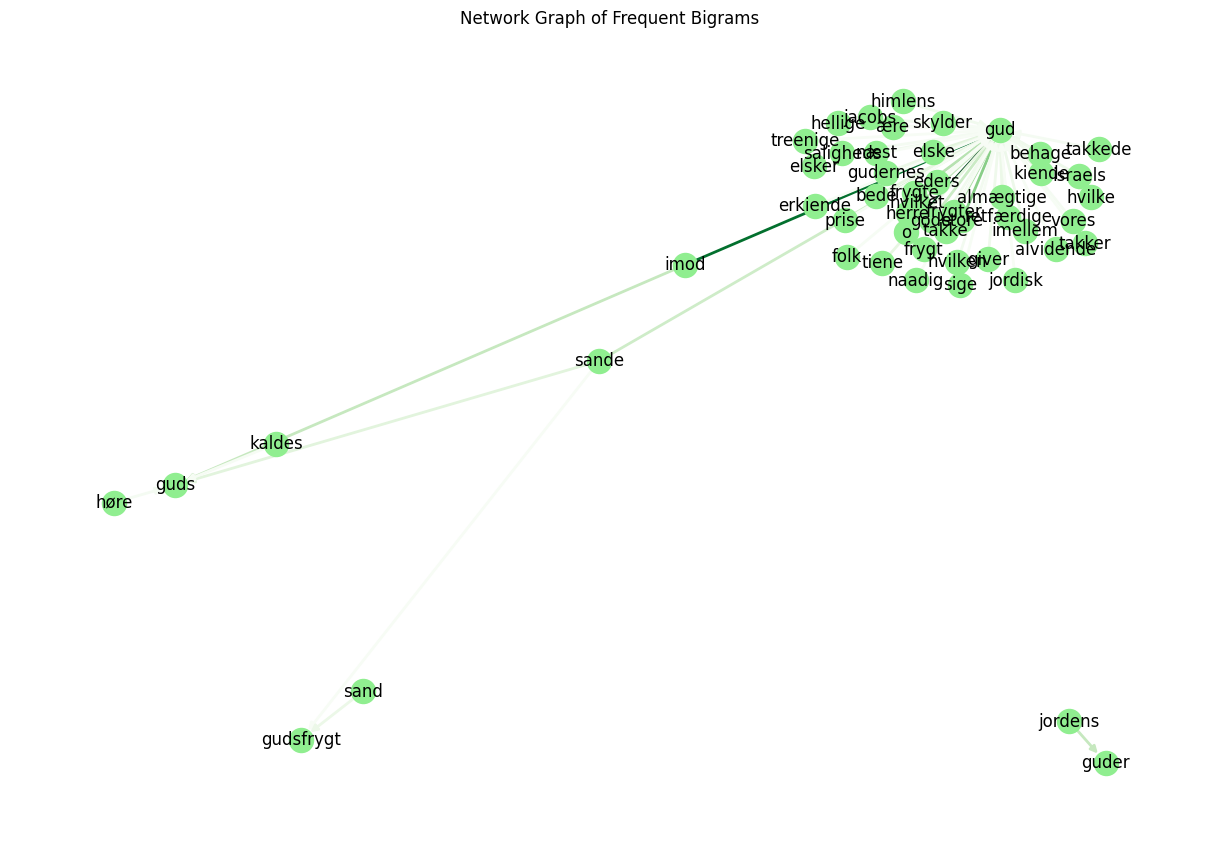

In [8]:
# Select bigrams that occur more than e.g., 8 times
threshold = 8
graph_data = match_counts[match_counts['count'] > threshold]

G = nx.DiGraph()
for _, row in graph_data.iterrows():
    G.add_edge(row['word1'], row['word2'], weight=row['count'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color=weights, width=2.0, edge_cmap=plt.cm.Greens, arrows=True)
plt.title('Network Graph of Frequent Bigrams')
plt.show()

## 9. Save Graph and Results

You can save the graph and results as CSV files.

In [9]:
bigram_counts_filtered.to_csv('results_bigrams_filtered.csv', index=False)
match_counts.to_csv('results_bigrams_match.csv', index=False)
plt.savefig('graphics/bigram_network.png', bbox_inches='tight', dpi=150)
print('Results and graph saved.')

Results and graph saved.


<Figure size 640x480 with 0 Axes>